# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [58]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [75]:
def code_cat_cols(X, cat_cols):
    return X[cat_cols].astype(str).astype('category').apply(lambda x: x.cat.codes)


def scale_num_cols(X, num_cols):
    return pd.DataFrame(StandardScaler().fit_transform(X[num_cols]), columns=num_cols).fillna(0).apply(np.float32)

def find_cat_num_cols(X):
    cat_cols = X.select_dtypes(exclude=["number","bool_"]).columns
    num_cols = list(set(X.columns) - set(cat_cols))
    return cat_cols, num_cols


def full_preprocess(X):
    cat_cols, num_cols = find_cat_num_cols(X)
    return pd.concat([code_cat_cols(X, cat_cols), scale_num_cols(X, num_cols)], axis=1)

In [60]:
X = pd.read_csv('data/orange_small_churn_data.train.csv')
y = pd.read_csv('data/orange_small_churn_labels.train.csv', header=None)

y = y[0].ravel()
y.reshape((40000,))

X_dropped = X.dropna(axis=1, thresh=20_000, how="any") 

cat_cols, num_cols = find_cat_num_cols(X_dropped)

X_cat = code_cat_cols(X_dropped, cat_cols)

X_scaled = scale_num_cols(X_dropped, num_cols)

X_processed = pd.concat([X_scaled, X_cat], axis=1)

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve


sizes, tr_scores, test_scores  = learning_curve(GradientBoostingClassifier(), X_processed, y, scoring='roc_auc')


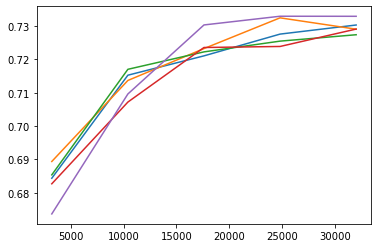

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sizes, test_scores);

In [63]:
from sklearn.model_selection import train_test_split


X_new, _, y_new, _ = train_test_split(X_processed, y, train_size=17_000)
X_new.shape

(17000, 69)

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [64]:
print((y_new == -1).sum() / y_new.shape[0], 'доля объектов первого класса')

0.9252941176470588 доля объектов первого класса


In [66]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression



print(cross_val_score(LogisticRegression(class_weight="balanced", max_iter=3000), X_new, y_new).mean(),
      cross_val_score(LogisticRegression(class_weight={-1: 0.1, 1: 0.9}, max_iter=3000), X_new, y_new).mean(),
      cross_val_score(LogisticRegression(class_weight={-1: 1, 1: 2}, max_iter=3000), X_new, y_new).mean())

0.5778823529411764 0.7577058823529411 0.9249411764705883


2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [67]:
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, NearMiss



X_resampled1, y_resampled1 = RandomUnderSampler(random_state=0).fit_resample(X_new, y_new)
X_resampled2, y_resampled2 = EditedNearestNeighbours().fit_resample(X_new, y_new)
X_resampled3, y_resampled3 = NearMiss().fit_resample(X_new,y_new)

In [68]:
print(cross_val_score(GradientBoostingClassifier(), X_resampled1, y_resampled1).mean(),
      cross_val_score(GradientBoostingClassifier(), X_resampled2, y_resampled2).mean(),
      cross_val_score(GradientBoostingClassifier(), X_resampled3, y_resampled3).mean())

0.6496062992125984 0.906072994641615 0.7318897637795276


3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [76]:
X_filled1 = X.fillna(method='bfill')
X_filled2 = X.fillna(method='pad')

X_filled1_processed = full_preprocess(X_filled1)
X_filled2_processed = full_preprocess(X_filled2)



In [79]:
print(cross_val_score(GradientBoostingClassifier(), X_filled1_processed, y).mean(),
      cross_val_score(GradientBoostingClassifier(), X_filled2_processed, y).mean())

0.916825 0.9159749999999999


4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


logreg1 = LogisticRegression(solver='liblinear', penalty='l1').fit(X_filled1_processed, y)
model1 = SelectFromModel(logreg1, prefit=True)
X_new1 = model1.transform(X_filled1_processed)
print(X_new1.shape)

rf = RandomForestClassifier().fit(X_filled1_processed, y)
model2 = SelectFromModel(rf, prefit=True)
X_new2 = model2.transform(X_filled1_processed)
print(X_new2.shape)


(40000, 188)
(40000, 78)


In [85]:
print(cross_val_score(GradientBoostingClassifier(), X_new1, y).mean(),
      cross_val_score(GradientBoostingClassifier(), X_new2, y).mean())

0.917975 0.91995


6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров на качество модели?

In [93]:
from sklearn.model_selection import RandomizedSearchCV


model = GradientBoostingClassifier()
grid = RandomizedSearchCV(model, 
                          {'learning_rate': np.arange(0.1, 1.0, 0.5),
                           'n_estimators': range(100, 300, 100),
                           'max_depth': range(2, 4)})

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [94]:
grid.feature_importances_

AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [99]:
# undersampling + отбросим часть объектов + отбросим часть признаков


rf = RandomForestClassifier().fit(X_resampled2, y_resampled2)
model = SelectFromModel(rf, prefit=True)
X_final = model.transform(X_resampled2)

In [101]:
grid.fit(X_final, y_resampled2)
grid.best_score_

0.9075984711733234

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Использовать более сложные модели, например, стэкинг бустингов